# West Nile Virus Prediction

### 1. Import Data and Libraries

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_curve, auc

%matplotlib inline

In [43]:
spray = pd.read_csv('./west_nile/west_nile/input/spray.csv')
weather = pd.read_csv('./west_nile/west_nile/input/weather.csv')
train = pd.read_csv('./west_nile/west_nile/input/train.csv')
ss = pd.read_csv('./west_nile/west_nile/input/SampleSubmission.csv')

In [44]:
#match this up with mosquito traps to see if areas with high reports for standing water have higher wnv/skeeter pops
sw = pd.read_csv('./west_nile/Sanitation_Status_map.csv')

### 2. Perform EDA /Format /Clean Data

In [45]:
def quick_EDA(df):
    #Input a dataframe, Returns: shape of data, number of nulls
    nulls = df.isnull().sum().sum()
    
    print('Rows:', df.shape[0], 'Columns:', df.shape[1])
    print('Total NaNs:', nulls)

In [46]:
quick_EDA(train)

Rows: 10506 Columns: 12
Total NaNs: 0


In [47]:
quick_EDA(spray)

Rows: 14835 Columns: 4
Total NaNs: 584


In [48]:
quick_EDA(weather)

Rows: 2944 Columns: 22
Total NaNs: 0


In [50]:
#Converting train columns to datetime format
train['Date'] = pd.to_datetime(train['Date'])

In [51]:
#converting spray columns to date time and making date/time columns
spray['Date'] = pd.to_datetime(spray['Date'])
spray['am_pm'] = spray['Time'].apply(lambda x: str(x).split()[-1])
spray['Time'] = spray['Time'].apply(lambda x: str(x).split()[0])
spray['Time'] = pd.to_datetime(spray['Time'], format = '%H:%M:%S')

In [52]:
#converting Weather columns to datetime
weather['Date'] = pd.to_datetime(weather['Date'])

In [53]:
#testing to see if any traps are ever tested more than once on the same day
    # none are, this will allow us to determine the number of mosquitos in traps where there are more than 50
    # because we can now combine rows on Trap Id and Date to get total no. mosquitos tested
datetrap = train[['Date', 'Trap']]
y = datetrap.merge(pd.get_dummies(train['Trap']), how = 'left', right_index = True, left_index = True)

datetrapcols = y.shape[1]
datetraprows = y.shape[0]
errors = 0

for i in range(datetraprows):
    for g in range(2,datetrapcols):
        if y.iloc[i,g] > 1:
            errors += 1
print('Traps tested > 1/day:', errors)

Traps tested > 1/day: 0


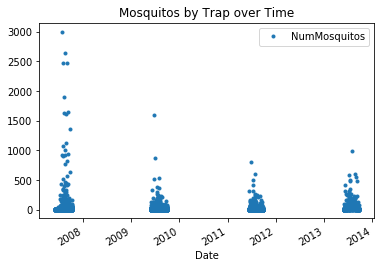

In [54]:
#plotted mosquitos by trap by date
train[['Date', 'Trap', 'NumMosquitos']].groupby(by = ['Date','Trap'])['Date','Trap','NumMosquitos'] \
    .sum().reset_index().sort_values('NumMosquitos', ascending = False).set_index('Date').plot(style = '.')
    
plt.title('Mosquitos by Trap over Time');

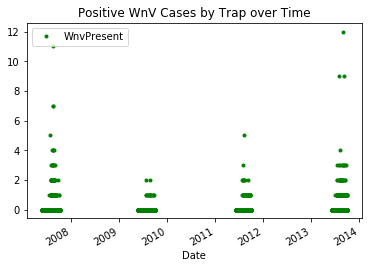

In [55]:
#plotted WNV incidents by trap
train[['Date', 'Trap','WnvPresent']].groupby(by = ['Date','Trap'])['Date','Trap','WnvPresent'] \
    .sum().reset_index().sort_values('WnvPresent', ascending = False).set_index('Date').plot(color = 'green', style = '.')
    
plt.title('Positive WnV Cases by Trap over Time');

### 3. Feature Engineering

##### Split out Parent Traps and Child Traps

In [56]:
#Create columns to show parent trap and child traps
train['Parent_Trap'] = train['Trap'].apply(lambda x: x[:4])
train['Child_Trap'] = train['Trap'].apply(lambda x: x[4:])

In [57]:
#show number of child traps to each parent trap
#need to de-duplicate list of traps initally to accomplish this
train[['Parent_Trap', 'Child_Trap']].drop_duplicates().groupby(by = 'Parent_Trap')['Child_Trap'].count().reset_index(). \
    sort_values(by = 'Child_Trap',ascending = False).reset_index(drop = True).head()

,Parent_Trap,Child_Trap
0,T094,2
1,T054,2
2,T001,1
3,T148,1
4,T143,1


##### Get Dummies for mosquito species

In [58]:
#split out dual mosquote species lines into separate columns
train['Species'] = train['Species'].apply(lambda x: x.split('/'))

train['Species1'] = train['Species'].apply(lambda x: 'CULEX ' + x[1] if len(x) == 2 else 'NaN')
train['Species0'] = train['Species'].apply(lambda x: x[0])

In [59]:
#make dummies for mosquito species
train = pd.get_dummies(train, prefix = 'Species', columns = ['Species0'])


In [60]:
#add in the RESTUANS species from the split column
for i in range(train.shape[0]):
    if train.loc[i, 'Species1'] == 'CULEX RESTUANS':
        train.loc[i,'Species_CULEX RESTUANS'] = 1

In [61]:
#drop the species column
train.drop(columns = ['Species','Species1'], inplace = True)

##### Get Dummies for Other Variables

In [65]:
dummy_train = pd.get_dummies(train, columns = ['Trap', 'Block', 'Street'])

train.drop(columns = ['Trap', 'Block', 'Street'], inplace = True)

##### Get Dummies for Time (Week, Month, Year)

In [63]:
#breaking week, month, and year into separate columns
train['Week'] = train['Date'].dt.week
train['Month'] = train['Date'].dt.month
train['Year'] = train['Date'].dt.year

#drop date column
train.drop(columns = 'Date', inplace = True)

#get dummies
train = pd.get_dummies(train, columns = ['Week', 'Month', 'Year'])

##### Drop Misc. Columns

In [67]:
train.drop(columns = ['Address', 'AddressNumberAndStreet', 'Latitude', \
                      'Longitude', 'AddressAccuracy', 'Parent_Trap', 'Child_Trap'], inplace = True)

### 4. Modeling

In [115]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from keras.models import Sequential
from keras.layers import Dense

##### Resampling Data for Classification Models

In [114]:
#this is the baseline accuracy to beat for classification models
#if we selected "WnV is not present for all samples" we would be correct ~95% of the time
format(1 - train['WnvPresent'].sum()/train.shape[0], '.3f')

'0.948'

In [117]:
#have to convert to numpy array for keras/tensorflow/classification
X = train.drop(columns = 'WnvPresent')
y = train['WnvPresent']

In [118]:
#prep data to enter models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [120]:
#rejoin train data on index so it can be downsampled to match classes
traindata = X_train.merge(pd.DataFrame(y_train), how = 'left', right_index = True, left_index = True)

#separate minority and majority classes
train_majority = traindata[traindata['WnvPresent'] == 0]
train_minority = traindata[traindata['WnvPresent'] == 1]

#upsample minority class
train_minority_upsampled = resample(train_minority, 
                                     replace = True, 
                                     n_samples = train_majority.shape[0],
                                     random_state = 65)
#combine classes
train_data_upsampled = pd.concat([train_majority, train_minority_upsampled])
#split back into X_train and y_train
X_train = train_data_upsampled.drop(columns = 'WnvPresent')
y_train = train_data_upsampled['WnvPresent']

#### A. Neural Network

In [128]:
#standardizing data to normalize with a mean of 0 and a stdDev of 1
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [129]:
#create model
model = Sequential()

In [152]:
#network topolgy
input_units = X_train.shape[1]
hidden_units = round(input_units)

model.add(Dense(hidden_units, 
                input_dim = input_units, 
                activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid'))

In [153]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['binary_accuracy'])

In [157]:
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   epochs = 500, 
                   batch_size = None, 
                   verbose = 1)

Train on 13938 samples, validate on 3152 samples
Epoch 1/500
13938/13938 [==============================] - 1s 77us/step - loss: 0.2264 - binary_accuracy: 0.9397 - val_loss: 0.3734 - val_binary_accuracy: 0.8890
Epoch 2/500
13938/13938 [==============================] - 1s 65us/step - loss: 0.2206 - binary_accuracy: 0.9417 - val_loss: 0.3672 - val_binary_accuracy: 0.8921
Epoch 3/500
13938/13938 [==============================] - 1s 67us/step - loss: 0.2191 - binary_accuracy: 0.9427 - val_loss: 0.3332 - val_binary_accuracy: 0.8972
Epoch 4/500
13938/13938 [==============================] - 1s 68us/step - loss: 0.2315 - binary_accuracy: 0.9379 - val_loss: 0.3518 - val_binary_accuracy: 0.8864
Epoch 5/500
13938/13938 [==============================] - 1s 69us/step - loss: 0.2244 - binary_accuracy: 0.9406 - val_loss: 0.3615 - val_binary_accuracy: 0.8886
Epoch 6/500
13938/13938 [==============================] - 1s 65us/step - loss: 0.2196 - binary_accuracy: 0.9427 - val_loss: 0.3496 - val_bin

13938/13938 [==============================] - 1s 49us/step - loss: 0.2222 - binary_accuracy: 0.9412 - val_loss: 0.3646 - val_binary_accuracy: 0.8905
Epoch 52/500
13938/13938 [==============================] - 1s 65us/step - loss: 0.2210 - binary_accuracy: 0.9422 - val_loss: 0.3498 - val_binary_accuracy: 0.8896
Epoch 53/500
13938/13938 [==============================] - 1s 47us/step - loss: 0.2212 - binary_accuracy: 0.9417 - val_loss: 0.3604 - val_binary_accuracy: 0.8915
Epoch 54/500
13938/13938 [==============================] - 1s 46us/step - loss: 0.2234 - binary_accuracy: 0.9408 - val_loss: 0.3572 - val_binary_accuracy: 0.8909
Epoch 55/500
13938/13938 [==============================] - 1s 51us/step - loss: 0.2267 - binary_accuracy: 0.9397 - val_loss: 0.3522 - val_binary_accuracy: 0.8867
Epoch 56/500
13938/13938 [==============================] - 1s 47us/step - loss: 0.2223 - binary_accuracy: 0.9414 - val_loss: 0.3663 - val_binary_accuracy: 0.8909
Epoch 57/500
13938/13938 [=========

13938/13938 [==============================] - 1s 47us/step - loss: 0.2191 - binary_accuracy: 0.9427 - val_loss: 0.3570 - val_binary_accuracy: 0.8928
Epoch 102/500
13938/13938 [==============================] - 1s 48us/step - loss: 0.2192 - binary_accuracy: 0.9428 - val_loss: 0.3554 - val_binary_accuracy: 0.8918
Epoch 103/500
13938/13938 [==============================] - 1s 46us/step - loss: 0.2184 - binary_accuracy: 0.9423 - val_loss: 0.3647 - val_binary_accuracy: 0.8944
Epoch 104/500
13938/13938 [==============================] - 1s 48us/step - loss: 0.2209 - binary_accuracy: 0.9420 - val_loss: 0.3329 - val_binary_accuracy: 0.8944
Epoch 105/500
13938/13938 [==============================] - 1s 46us/step - loss: 0.2262 - binary_accuracy: 0.9398 - val_loss: 0.3638 - val_binary_accuracy: 0.8893
Epoch 106/500
13938/13938 [==============================] - 1s 46us/step - loss: 0.2207 - binary_accuracy: 0.9418 - val_loss: 0.3514 - val_binary_accuracy: 0.8928
Epoch 107/500
13938/13938 [===

13938/13938 [==============================] - 1s 46us/step - loss: 0.2229 - binary_accuracy: 0.9412 - val_loss: 0.3539 - val_binary_accuracy: 0.8902
Epoch 152/500
13938/13938 [==============================] - 1s 46us/step - loss: 0.2202 - binary_accuracy: 0.9422 - val_loss: 0.3565 - val_binary_accuracy: 0.8896
Epoch 153/500
13938/13938 [==============================] - 1s 46us/step - loss: 0.2221 - binary_accuracy: 0.9414 - val_loss: 0.3561 - val_binary_accuracy: 0.8915
Epoch 154/500
13938/13938 [==============================] - 1s 47us/step - loss: 0.2211 - binary_accuracy: 0.9418 - val_loss: 0.3526 - val_binary_accuracy: 0.8902
Epoch 155/500
13938/13938 [==============================] - 1s 46us/step - loss: 0.2189 - binary_accuracy: 0.9425 - val_loss: 0.3451 - val_binary_accuracy: 0.8963
Epoch 156/500
13938/13938 [==============================] - 1s 47us/step - loss: 0.2158 - binary_accuracy: 0.9440 - val_loss: 0.3558 - val_binary_accuracy: 0.8931
Epoch 157/500
13938/13938 [===

13938/13938 [==============================] - 1s 64us/step - loss: 0.2198 - binary_accuracy: 0.9424 - val_loss: 0.3438 - val_binary_accuracy: 0.8912
Epoch 202/500
13938/13938 [==============================] - 1s 58us/step - loss: 0.2198 - binary_accuracy: 0.9424 - val_loss: 0.3654 - val_binary_accuracy: 0.8905
Epoch 203/500
13938/13938 [==============================] - 1s 49us/step - loss: 0.2203 - binary_accuracy: 0.9425 - val_loss: 0.3491 - val_binary_accuracy: 0.8915
Epoch 204/500
13938/13938 [==============================] - 1s 45us/step - loss: 0.2215 - binary_accuracy: 0.9417 - val_loss: 0.3671 - val_binary_accuracy: 0.8909
Epoch 205/500
13938/13938 [==============================] - 1s 46us/step - loss: 0.2196 - binary_accuracy: 0.9422 - val_loss: 0.3431 - val_binary_accuracy: 0.8912
Epoch 206/500
13938/13938 [==============================] - 1s 46us/step - loss: 0.2188 - binary_accuracy: 0.9430 - val_loss: 0.3585 - val_binary_accuracy: 0.8915
Epoch 207/500
13938/13938 [===

13938/13938 [==============================] - 1s 43us/step - loss: 0.2174 - binary_accuracy: 0.9431 - val_loss: 0.3535 - val_binary_accuracy: 0.8931
Epoch 252/500
13938/13938 [==============================] - 1s 43us/step - loss: 0.2177 - binary_accuracy: 0.9430 - val_loss: 0.3733 - val_binary_accuracy: 0.8909
Epoch 253/500
13938/13938 [==============================] - 1s 44us/step - loss: 0.2227 - binary_accuracy: 0.9406 - val_loss: 0.3557 - val_binary_accuracy: 0.8915
Epoch 254/500
13938/13938 [==============================] - 1s 43us/step - loss: 0.2196 - binary_accuracy: 0.9422 - val_loss: 0.3441 - val_binary_accuracy: 0.8928
Epoch 255/500
13938/13938 [==============================] - 1s 65us/step - loss: 0.2197 - binary_accuracy: 0.9421 - val_loss: 0.3509 - val_binary_accuracy: 0.8902
Epoch 256/500
13938/13938 [==============================] - 1s 45us/step - loss: 0.2217 - binary_accuracy: 0.9417 - val_loss: 0.3499 - val_binary_accuracy: 0.8909
Epoch 257/500
13938/13938 [===

13938/13938 [==============================] - 1s 43us/step - loss: 0.2233 - binary_accuracy: 0.9409 - val_loss: 0.3422 - val_binary_accuracy: 0.8928
Epoch 302/500
13938/13938 [==============================] - 1s 43us/step - loss: 0.2180 - binary_accuracy: 0.9432 - val_loss: 0.3384 - val_binary_accuracy: 0.8950
Epoch 303/500
13938/13938 [==============================] - 1s 43us/step - loss: 0.2233 - binary_accuracy: 0.9411 - val_loss: 0.3445 - val_binary_accuracy: 0.8937
Epoch 304/500
13938/13938 [==============================] - 1s 49us/step - loss: 0.2253 - binary_accuracy: 0.9404 - val_loss: 0.3461 - val_binary_accuracy: 0.8905
Epoch 305/500
13938/13938 [==============================] - 1s 45us/step - loss: 0.2226 - binary_accuracy: 0.9412 - val_loss: 0.3497 - val_binary_accuracy: 0.8937
Epoch 306/500
13938/13938 [==============================] - 1s 43us/step - loss: 0.2196 - binary_accuracy: 0.9423 - val_loss: 0.3590 - val_binary_accuracy: 0.8940
Epoch 307/500
13938/13938 [===

13938/13938 [==============================] - 1s 42us/step - loss: 0.2503 - binary_accuracy: 0.9306 - val_loss: 0.3570 - val_binary_accuracy: 0.8934
Epoch 352/500
13938/13938 [==============================] - 1s 57us/step - loss: 0.2186 - binary_accuracy: 0.9426 - val_loss: 0.3427 - val_binary_accuracy: 0.8947
Epoch 353/500
13938/13938 [==============================] - 1s 43us/step - loss: 0.2228 - binary_accuracy: 0.9411 - val_loss: 0.3557 - val_binary_accuracy: 0.8902
Epoch 354/500
13938/13938 [==============================] - 1s 43us/step - loss: 0.2248 - binary_accuracy: 0.9406 - val_loss: 0.3487 - val_binary_accuracy: 0.8953
Epoch 355/500
13938/13938 [==============================] - 1s 43us/step - loss: 0.2547 - binary_accuracy: 0.9291 - val_loss: 0.3592 - val_binary_accuracy: 0.8947
Epoch 356/500
13938/13938 [==============================] - 1s 57us/step - loss: 0.2558 - binary_accuracy: 0.9289 - val_loss: 0.3493 - val_binary_accuracy: 0.8966
Epoch 357/500
13938/13938 [===

13938/13938 [==============================] - 1s 72us/step - loss: 0.2186 - binary_accuracy: 0.9429 - val_loss: 0.3422 - val_binary_accuracy: 0.8953
Epoch 402/500
13938/13938 [==============================] - 1s 84us/step - loss: 0.2156 - binary_accuracy: 0.9438 - val_loss: 0.3400 - val_binary_accuracy: 0.8944
Epoch 403/500
13938/13938 [==============================] - 1s 68us/step - loss: 0.2153 - binary_accuracy: 0.9442 - val_loss: 0.3498 - val_binary_accuracy: 0.8944
Epoch 404/500
13938/13938 [==============================] - 1s 70us/step - loss: 0.2158 - binary_accuracy: 0.9441 - val_loss: 0.3423 - val_binary_accuracy: 0.8937
Epoch 405/500
13938/13938 [==============================] - 1s 43us/step - loss: 0.2171 - binary_accuracy: 0.9433 - val_loss: 0.3473 - val_binary_accuracy: 0.8924
Epoch 406/500
13938/13938 [==============================] - 1s 43us/step - loss: 0.2259 - binary_accuracy: 0.9402 - val_loss: 0.3569 - val_binary_accuracy: 0.8899
Epoch 407/500
13938/13938 [===

13938/13938 [==============================] - 1s 46us/step - loss: 0.2248 - binary_accuracy: 0.9402 - val_loss: 0.3516 - val_binary_accuracy: 0.8921
Epoch 452/500
13938/13938 [==============================] - 1s 61us/step - loss: 0.2176 - binary_accuracy: 0.9432 - val_loss: 0.3445 - val_binary_accuracy: 0.8944
Epoch 453/500
13938/13938 [==============================] - 1s 60us/step - loss: 0.2165 - binary_accuracy: 0.9438 - val_loss: 0.3537 - val_binary_accuracy: 0.8937
Epoch 454/500
13938/13938 [==============================] - 1s 55us/step - loss: 0.2169 - binary_accuracy: 0.9434 - val_loss: 0.3568 - val_binary_accuracy: 0.8940
Epoch 455/500
13938/13938 [==============================] - 1s 52us/step - loss: 0.2171 - binary_accuracy: 0.9433 - val_loss: 0.3601 - val_binary_accuracy: 0.8921
Epoch 456/500
13938/13938 [==============================] - 1s 51us/step - loss: 0.2158 - binary_accuracy: 0.9439 - val_loss: 0.3398 - val_binary_accuracy: 0.8956
Epoch 457/500
13938/13938 [===

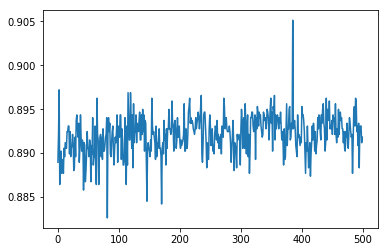

In [158]:
#plotting accuracy over epochs
plt.plot(history.history['val_binary_accuracy'])

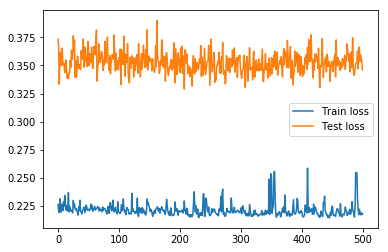

In [159]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(train_loss, label = 'Train loss')
plt.plot(test_loss, label = 'Test loss')
plt.legend();

In [ ]:
#get keras predictions to make a roc curve/get that roc auc

In [151]:
# as predicted from total data set only around 5% of all samples test positive for WnV
# preliminarily it appears that from upsampling the wnv cases to get a 50/50 test split
# for our neural network we are achieving around 88% accuracy against the test set
# compared to our baseline of 95% we would be better off guessing that all do not have WnV
(y_test.sum()/y_test.shape)[0]

0.05266497461928934

In [ ]:
#need to implement a confusion matrix in order to score this appropriately, will never beat 95%